- CNN MNIST 복습


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import time

In [2]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

train_x = raw_train_x/255
test_x = raw_test_x/255

train_x = train_x.reshape((60000, 28, 28, 1))
test_x = test_x.reshape((10000, 28, 28, 1))

train_y = raw_train_y
test_y = raw_test_y

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
model = keras.Sequential()
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [4]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

####<br>

# **1. Functional API**
- API보다 더 유연한 모델을 만드는 방법
- 비선형 토폴로지, 공유 레이어, 심지어 여러 입력 또는 출력으로 모델을 처리할 수 있음
- 딥 러닝 모델은 일반적으로 레이어에 지시된 비순환 그래프(DAG)이므로 Functional API는 레이어의 그래프를 작성하는 것이다. 라는게 핵심 아이디어
- Reference: https://keras.io/guides/functional_api/

## 1-1. Functional API의 기본 내용 이해
- 예시 모델
```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```
- 이 그래프는 세 개의 레이어가 있는 기본 그래프
- Functional API를 이용하여 이 모델을 빌드해 보자

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
inputs = keras.Input(shape=(784,))
inputs.shape

TensorShape([None, 784])

In [11]:
inputs.dtype

tf.float32

In [16]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

In [17]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


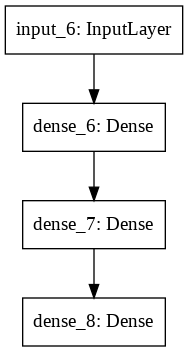

In [19]:
keras.utils.plot_model(model, "my_first_model.png")       # 모델을 그래프로 플롯할 수 있다.

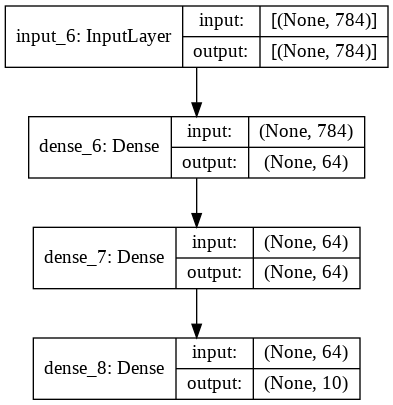

In [20]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)     # 플롯 된 그래프에 각 레이어의 입력 및 출력 모양을 표시할 수 있다

In [21]:
# 모델의 학습과 평가
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
750/750 [==============================] - 2s 3ms/step - loss: 0.3465 - accuracy: 0.9014 - val_loss: 0.1830 - val_accuracy: 0.9474
Epoch 2/2
750/750 [==============================] - 2s 3ms/step - loss: 0.1597 - accuracy: 0.9520 - val_loss: 0.1290 - val_accuracy: 0.9603
313/313 - 0s - loss: 0.1311 - accuracy: 0.9609
Test loss: 0.1310815066099167
Test accuracy: 0.9609000086784363


In [23]:
# 모델의 저장과 읽기
model.save("path_to_my_model")
del model

model = keras.models.load_model("path_to_my_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


####<br>
- 동일한 레이어 그래프를 사용하여 여러 모델을 정의할 수 있다.

In [24]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

In [25]:
x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                

####<br>
- 모든 모델은 레이어와 마찬가지로 호출할 수 있다.

In [27]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 16)                0   

####<br>
- 모든 모델은 중첩할 수 있다: (모델은 레이어와 같기 때문에) 모델은 하위 모델을 포함할 수 있습니다. 
- 모델 중첩에 대한 일반적인 사용 사례는 ensembling
####<br>
- 예시: 모델 집합을 예측을 평균하는 단일 모델로 변환하는 방법

In [28]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

####<br>
## 1-2. 복잡한 그래프 토폴로지 조작하기
- 여러 입력 및 출력을 갖춘 모델
  - Functional API를 사용하면 여러 입력 및 출력을 쉽게 조작할 수 있다.
  - 이 문제는 일반 API로는 처리할 수 없다.
####<br>
- 예시: 고객 문제 티켓을 우선 순위로 순위를 매기고 올바른 부서로 라우팅하는 시스템을 빌드하는 경우
  - 입력
    - 티켓 제목(텍스트 입력),
    - 티켓의 텍스트 본문(텍스트 입력) 및
    - 사용자가 추가한 태그(범주 입력)
  - 출력
    - 0과 1 사이의 우선 순위 점수 (스칼라 시그모이드 출력)
    - 티켓을 처리해야 하는 부서(부서 집합에 대한 소프트맥스 출력)
  - Functional API를 사용하면 몇 줄만으로 구현할 수 있음

In [29]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

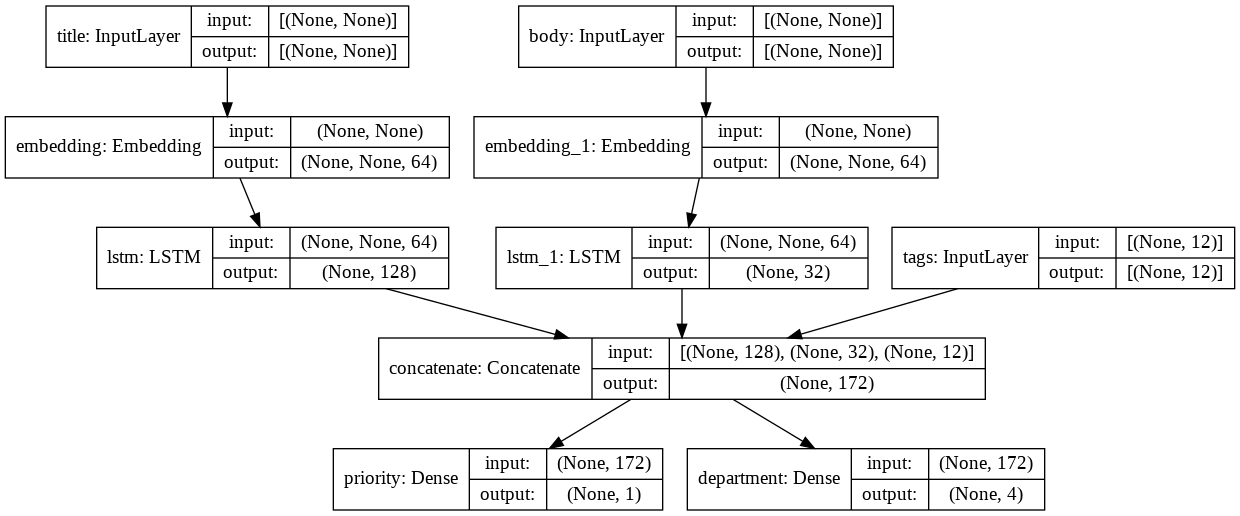

In [30]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

####<br>
- 모델을 컴파일할 때 각 출력에 다른 손실을 할당하거나, 각 손실에 다른 가중치를 할당하여 총 훈련 손실에 대한 기여를 조절할 수도 있음

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

####<br>
- 출력 레이어의 이름이 다르므로 해당 레이어 이름으로 손실 및 손실 가중치를 지정할 수 있음

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

####<br>
- 입력 및 대상의 NumPy 배열 목록을 전달하여 모델을 학습시키기

In [33]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 5s 55ms/step - loss: 1.2898 - priority_loss: 0.7001 - department_loss: 2.9483
Epoch 2/2
40/40 [==============================] - 2s 53ms/step - loss: 1.2873 - priority_loss: 0.7003 - department_loss: 2.9346


## 1-2. 장난감 ResNet 모델
- 여러 입력 및 출력이 있는 모델 외에도 Functional API를 사용하면 비선형 연결 토폴로지(topologies)를 쉽게 조작할 수 있음
- 이는 API로 처리할 수 없는 순차적으로 연결되지 않은 레이어가 있는 모델임

In [34]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_11[0][0]                  
_________________________________________________________________________________________

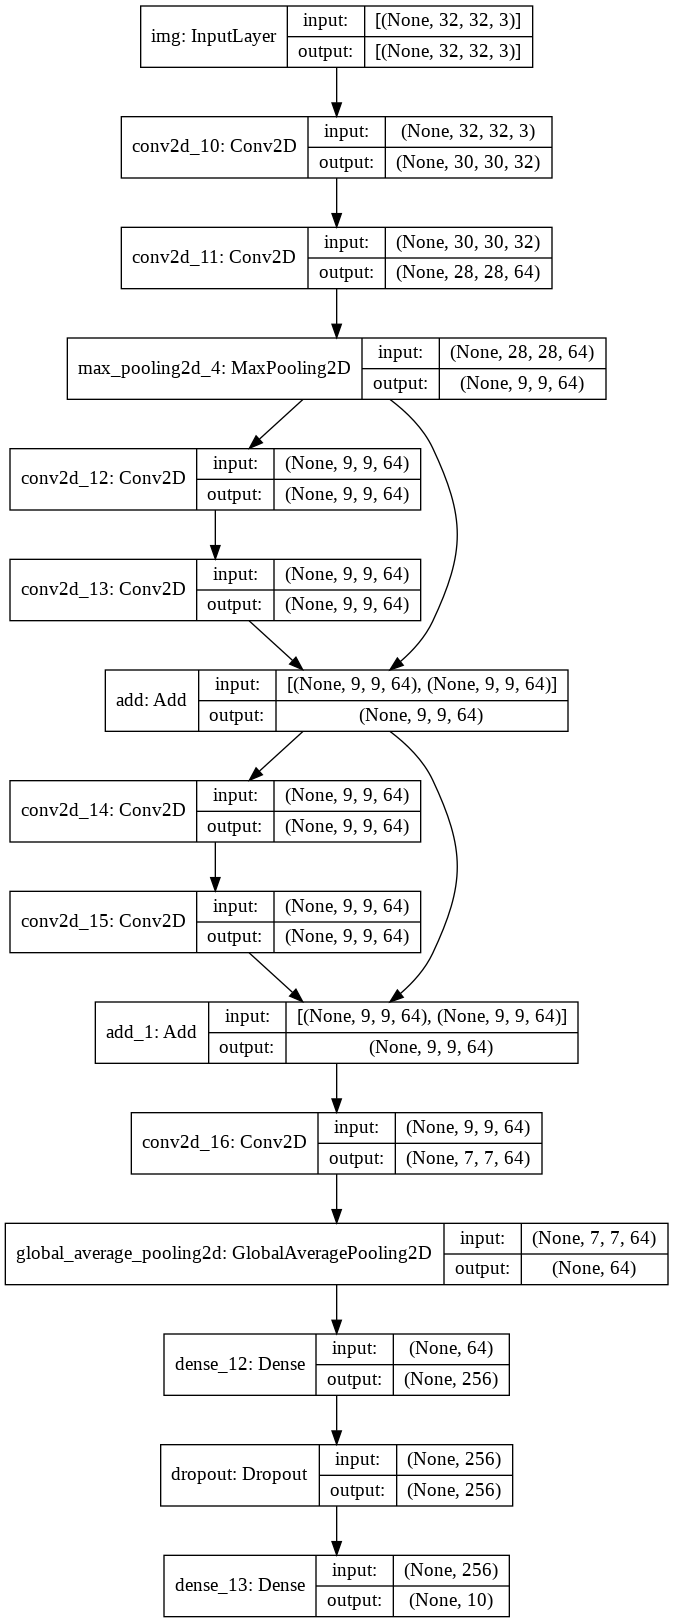

In [35]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [36]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

13/13 [==============================] - 5s 317ms/step - loss: 2.3239 - acc: 0.1075 - val_loss: 2.3029 - val_acc: 0.1300


## 1-3. 공유 레이어
- Functional API에 대한 또 다른 좋은 용도는 공유 레이어를사용하는 모델
- 공유 레이어는 동일한 모델에서 여러 번 재사용되는 레이어 인스턴스로 레이어 그래프의 여러 경로에 해당하는 피처를 학습
####<br>
- 공유 레이어는 종종 유사한 공간에서 입력을 인코딩하는 데 사용됨(예: 유사한 어휘를 특징으로 하는 두 개의 서로 다른 텍스트 조각). 
- 이러한 다양한 입력에 걸쳐 정보를 공유할 수 있으며, 이러한 모델을 더 적은 데이터로 학습할 수 있음
- 지정된 단어가 입력 중 하나에서 보이는 경우 공유 계층을 통과하는 모든 입력의 처리에 도움이 됨
####<br>
- Fucntional API에서 레이어를 공유하려면 동일한 레이어 인스턴스를 여러 번 호출
- 예시: 두 개의 서로 다른 텍스트 입력에 공유된 레이어

In [37]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## 1-4. 레이어 그래프에서 노트 추출 및 재사용
- 조작하는 레이어의 그래프는 정적 데이터 구조이므로 액세스하여 검사할 수 있음
- 이것은 기능 모델을 이미지로 플롯 할 수 있는 방법이며
- 중간 레이어(그래프의 "노드")의 활성화에 액세스하여 다른 곳에서 다시 사용할 수 있음을 의미함
- 이는 피처 추출과 같은 것에 매우 유용함
####<br>
- 예시: ImageNet에 미리 훈련 된 가중치가 적용된 VGG19 모델

In [38]:
vgg19 = tf.keras.applications.VGG19()

574717952/574710816 [==============================] - 13s 0us/step


- 그래프 데이터 구조를 쿼리하여 얻은 모델의 중간 활성화

In [40]:
features_list = [layer.output for layer in vgg19.layers]
features_list

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_13')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv4')>

- 이러한 기능을 사용하여 중간 레이어 활성화의 값을 반환하는 새 피처 추출 모델을 만들기
  - 예시와 같은 활용은 Neural Style Transfer 등의 작업에서 사용하기 편리함

In [42]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)
extracted_features

[<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
 array([[[[1.60642862e-01, 7.10515380e-01, 7.00894833e-01],
          [8.19155633e-01, 1.66392460e-01, 5.08765221e-01],
          [4.76708084e-01, 1.98027283e-01, 5.31902969e-01],
          ...,
          [1.82878926e-01, 1.49069175e-01, 8.77248228e-01],
          [4.17045057e-01, 2.05309689e-01, 4.22755390e-01],
          [5.40100336e-01, 1.67028695e-01, 7.70139098e-01]],
 
         [[7.06463397e-01, 1.66216508e-01, 3.00324470e-01],
          [1.50127456e-01, 9.42795098e-01, 7.78944910e-01],
          [7.23268511e-03, 4.85388458e-01, 2.70578712e-01],
          ...,
          [2.83104211e-01, 4.97657031e-01, 7.93627203e-01],
          [6.72562063e-01, 8.30910623e-01, 7.60012984e-01],
          [7.04533994e-01, 2.02976614e-01, 2.15523690e-01]],
 
         [[8.08318794e-01, 5.86164892e-01, 1.05435150e-02],
          [1.76309884e-01, 7.53748596e-01, 5.96190751e-01],
          [1.38715476e-01, 6.35167956e-01, 9.07160223e-01],
     

## 1-5. 사용자 지정 레이어를 사용하여 API 확장하기
- 케라스에서 지원되는 다양한 기본 제공 레이어
  - 컨볼루션 레이어: Conv1D, Conv2D, Conv3D, Conv2DTranspose
  - 풀링 레이어: MaxPooling1D, MaxPooling2D, MaxPooling3D, AveragePooling1D
  - RNN 레이어: GRU, LSTM, ConvLSTM2D
  - BatchNormalization
  - Dropout
  - Embedding 등
####<br>
- 만약 필요한 것을 찾지 못하면 자체 레이어를 만들어 API를 쉽게 확장할 수 있음
- 모든 레이어는 클래스를 하위로 분류하고 구현함
  - call: 레이어에서 수행한 계산을 지정하는 메서드
  - build: 레이어의 가중치를 만드는 메서드

In [44]:
# 기본 구현 형태
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)


# 사용자 지정 계층의 직렬화 지원의 경우 레이어 인스턴스의 생성자 인수를 반환하는 메서드 정의
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})


# (선택) 환경 정보가 담긴 딕셔너리 데이터가 주어진 레이어 인스턴스를 다시 만들 때 사용되는 클래스 메서드를 구현(기본 형태)
def from_config(cls, config):
  return cls(**config)

## 1-6. Functional API는 언제 사용하는가?
- Keras 기능 API를 사용하여 새 모델을 만들거나 클래스를 직접 하위 클래스로 조정해야 할 때
  - 일반적으로 Functional API는 더 높은 수준이고, 쉽고, 안전하며 모델 하위 클래스링이 지원하지 않는 여러 기능을 제공함
    - 모델 하위 클래스링은 레이어의 방향 비순환 그래프로 쉽게 표현할 수 없는 모델을 빌드할 때 더 큰 유연성을 제공함
    - 예를 들면, Functional API를 사용하여 Tree-RNN을 구현할 수 없으며 직접 하위 클래스를 조정해야 함

In [ ]:
# Functional API 버전
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)


# 하위 클래스링 버전
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

mlp = MLP()     # Instantiate the model.

_ = mlp(tf.zeros((1, 32)))    # Necessary to create the model's state. The model doesn't have a state until it's called at least once.

- Functional API의 강점
  - 연결 그래프를 정의하는 동안 모델 유효성 검사 가능
    - Functional API에서 입력 사양은 사전에 미리 만들어짐. 
    - 레이어를 호출할 때마다 레이어는 전달된 사양이 가정과 일치하는지 확인하고 그렇지 않은 경우 유용한 오류 메시지가 표시됨
    - 이렇게 하면 Functional API로 빌드할 수 있는 모든 모델이 실행됨
    - 수렴 관련 디버깅을 제외한 모든 디버깅은 실행 시간이 아닌 모델 구성 중에 정적으로 발생함(컴파일러의 체크 인 형식과 유사)
  - 기능 모델은 플롯이 가능하고 내용을 검사할 수 있음
    - 모델을 그래프로 플롯할 수 있으며 이 그래프의 중간 노드에 쉽게 액세스할 수 있음
    - 예를 들어 중간 레이어의 활성화를 추출하고 다시 사용하려는 경우
  - Functional 모델을 직렬화하거나 복제할 수 있음
    - Functional 모델은 코드 조각이 아닌 데이터 구조이므로 안전하게 직렬화(저장)할 수 있으며 원래 코드에 액세스하지 않고도 동일한 모델을 다시 만들 수 있는 단일 파일로 저장 가능
    - 하위 클래스 모델을 직렬화하려면 구현자가 모델 수준에서 및 메서드를 지정해야 함

####<br>
- Functional API의 단점
  - 동적 아키첵처를 지원하지 않음
    - Functional API는 모델을 레이어의 DAG로 처리하는데 이는 대부분의 딥 러닝 아키텍처에 해당하지만 전부는 아님
    - 예: 재귀 네트워크 또는 Tree RNN는 이 가정을 따르지 않으며 Functional API에서 구현할 수 없음

In [45]:
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

## 1-7. Mix-and-Match API 스타일
- Functional API의 모든 모델은 모델, 기능 모델 또는 처음부터 작성된 하위 분류 모델이든 관계없이 서로 상호 작용할 수 있음
- 항상 하위 클래스 모델 또는 레이어의 일부로 기능 모델 또는 모델을 사용할 수 있음

In [46]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

(1, 10, 32)


- 다음 패턴 중 하나를 따르는 메서드를 구현하는 한, Functional API에서 하위 클래스계층 또는 모델을 사용할 수 있음
  - call(self, inputs, **kwargs) : 텐서, 텐서의 중첩 된 구조(텐서 목록 등), 그리고 비 텐서 인수의 위치
  - call(self, inputs, training=None, **kwargs) : 학습 모드와 예측 모드 중 어디에서 동작해야 하는지 여부를 나타내는 불린 값
  - call(self, inputs, mask=None, **kwargs) : 불린 마스크 텐서
  - call(self, inputs, training=None, mask=None, **kwargs) : 마스킹과 트레이닝별 동작을 동시에 수행할 수 있음
- 사용자 지정 레이어 또는 모델에 메서드를 구현하는 경우 만든 Functional Model은 여전히 직렬화(저장)가능하고 복제할 수 있음
####<br>
Functional Model에서 사용되는 사용자 지정 RNN의 예

In [47]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))

## 1-8. Functional API 타입의 CNN MNIST

### 1-8-1. 기본 코드

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import time

In [ ]:
# model = keras.Sequential()
# model.add(Input((28,28,1)))
# model.add(Conv2D(32, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(10, activation='softmax'))

from tensorflow.keras import Model

input = Input((28,28,1))
x = Conv2D(32, (3,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(input, output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                8010  

### 1-8-2. 다중 입력

- copy from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/


#### (1) 데이터 준비

In [ ]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2166
Receiving objects: 100% (2166/2166), 176.26 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (20/20), done.


```
Houses-dataset/
  Houses Dataset/
    100_bathroom.jpg
    100_bedroom.jpg
    ...
    HousesInfo.txt
```

In [ ]:
!head 'Houses-dataset/Houses Dataset/HousesInfo.txt'

4 4 4053 85255 869500
4 3 3343 36372 865200
3 4 3923 85266 889000
5 5 4022 85262 910000
3 4 4116 85266 971226
4 5 4581 85266 1249000
3 4 2544 85262 799000
4 5 5524 85266 1698000
3 4 4229 85255 1749000
4 5 3550 85262 1500000


In [ ]:
import matplotlib

from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_house_attributes(inputPath):

	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
 
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
   
	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
 
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
 
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
 
	# return the concatenated training and testing data
	return (trainX, testX)  

In [ ]:
def load_house_images(df, inputPath):

	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
  
		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")
  
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)
   
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
  
	# return our set of images
	return np.array(images)  

#### (2) 값 정보 읽기

In [ ]:
df = load_house_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")

In [ ]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


#### (3) 영상 데이터 읽기

In [ ]:
images = load_house_images(df, "Houses-dataset/Houses Dataset/")
images = images/255.

In [ ]:
print(images.shape)

(362, 64, 64, 3)


In [ ]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

In [ ]:
print("tainAttrX.shape=", trainAttrX.shape)
print("trainImagesX.shape=", trainImagesX.shape)
print("trainY.shape=", trainY.shape)
print("testAttrX.shape=", testAttrX.shape)
print("testImageX.shape=", testImagesX.shape)
print("testY.shape=", testY.shape)

tainAttrX.shape= (271, 10)
trainImagesX.shape= (271, 64, 64, 3)
trainY.shape= (271,)
testAttrX.shape= (91, 10)
testImageX.shape= (91, 64, 64, 3)
testY.shape= (91,)


In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

#### (4) 개별 모델로 학습 실행: 속성 모델

In [ ]:
input = Input(trainAttrX[0].shape)
x = Dense(10, activation='relu')(input)
x = Dense(10, activation='relu')(x)
output = Dense(1)(x)

attr_model = Model(input, output)

In [ ]:
attr_model.compile(optimizer="adam", loss="mse")
attr_model.summary()

attr_model.fit(trainAttrX, trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds = attr_model.predict(testAttrX)

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 38.70%, std: 61.30


#### (5) 개별 모델로 학습 진행: 영상 모델

In [ ]:
input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(1)(x)

image_model = Model(input, output)

In [ ]:
image_model.compile(optimizer="adam", loss="mse")
image_model.summary()

image_model.fit(trainImagesX, trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                6273

In [ ]:
preds = image_model.predict(testImagesX)

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 96.52%, std: 149.13


#### (6) 다중 입력 모델로 학습 실행

In [ ]:
attr_input = Input(trainAttrX[0].shape)
x = Dense(10, activation='relu')(attr_input)
attr_out = Dense(10, activation='linear')(x)

image_input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

combined_input = concatenate([attr_out, image_output])

x = Dense(4, activation="relu")(combined_input)
output = Dense(1)(x)


combined_model = Model([attr_input, image_input], output)

In [ ]:
combined_model.compile(optimizer="adam", loss="mse")
combined_model.summary()

combined_model.fit([trainAttrX, trainImagesX], trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 62, 62, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 31, 31, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 29, 29, 32)   9248        max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [ ]:
preds = combined_model.predict([testAttrX, testImagesX])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 115.42%, std: 189.54


### 1-8-3. 다중 출력
- copy from https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

#### (1) 데이터 준비

In [ ]:
!wget https://github.com/dhrim/pis_study/raw/master/multi_label_classification/fashion_dataset.zip

--2020-07-16 02:46:57--  https://github.com/dhrim/pis_study/raw/master/multi_label_classification/fashion_dataset.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/pis_study/master/multi_label_classification/fashion_dataset.zip [following]
--2020-07-16 02:46:58--  https://raw.githubusercontent.com/dhrim/pis_study/master/multi_label_classification/fashion_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26991216 (26M) [application/zip]
Saving to: ‘fashion_dataset.zip’

fashion_dataset.zip 100%[===================>]  25.74M  35.8MB/s    in 0.7s    

2020-07-16 02:47:00 (35.8 MB/s) - 

In [ ]:
!ls -alh

total 26M
drwxr-xr-x 1 root root 4.0K Jul 16 02:46 .
drwxr-xr-x 1 root root 4.0K Jul 16 02:33 ..
drwxr-xr-x 1 root root 4.0K Jul 13 16:14 .config
-rw-r--r-- 1 root root  26M Jul 16 02:47 fashion_dataset.zip
drwxr-xr-x 4 root root 4.0K Jul 16 02:42 Houses-dataset
drwxr-xr-x 1 root root 4.0K Jul 10 16:29 sample_data


In [ ]:
!unzip fashion_dataset.zip

Archive:  fashion_dataset.zip
   creating: fashion_dataset/
   creating: fashion_dataset/black_jeans/
  inflating: fashion_dataset/black_jeans/00000000.jpg  
   creating: __MACOSX/
   creating: __MACOSX/fashion_dataset/
   creating: __MACOSX/fashion_dataset/black_jeans/
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000000.jpg  
  inflating: fashion_dataset/black_jeans/00000004.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000004.jpg  
  inflating: fashion_dataset/black_jeans/00000006.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000006.jpg  
  inflating: fashion_dataset/black_jeans/00000007.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000007.jpg  
  inflating: fashion_dataset/black_jeans/00000009.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000009.jpg  
  inflating: fashion_dataset/black_jeans/00000010.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000010.jpg  
  inflating: fashion_dataset/black_jeans/000000

```
fashion_dataset/
  black_jeans
  black_shoes/
  blue_dress/
  blue_jeans
  blue_shirt/
  red_dress/
  red_shirt/
```

```
category : jeans, shoes, dress, shirt
color : black, blue, red
```

In [ ]:
import matplotlib

from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [ ]:
IMAGE_DIMS = (96, 96, 3)

#### (2) 영상 파일이름 읽기

In [ ]:
imagePaths = sorted(list(paths.list_images('fashion_dataset')))
random.shuffle(imagePaths)
print(len(imagePaths))
print(imagePaths[:3])

755
['fashion_dataset/black_jeans/00000198.jpg', 'fashion_dataset/black_jeans/00000064.jpg', 'fashion_dataset/blue_shirt/00000079.jpg']


#### (3) 영상 읽기, 카테고리와 컬러 읽기

In [ ]:
data = []
categoryLabels = []
colorLabels = []

for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
  # imagePath = 'fashion_dataset/black_shoes/00000048.jpg'
  # color = 'black'
  # cat = 'shoes'
	categoryLabels.append(cat)
	colorLabels.append(color)

In [ ]:
print(categoryLabels[:10])
print(colorLabels[:10])

['jeans', 'jeans', 'shirt', 'jeans', 'dress', 'dress', 'shoes', 'dress', 'shoes', 'shoes']
['black', 'black', 'blue', 'black', 'red', 'blue', 'black', 'blue', 'black', 'black']


755 755 755
iamgePaths[0]= fashion_dataset/black_jeans/00000198.jpg


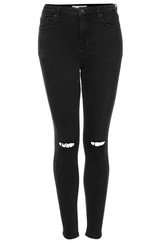

data[0]= (96, 96, 3)
categoryLabels[0]= jeans
colorLabels[0]= black


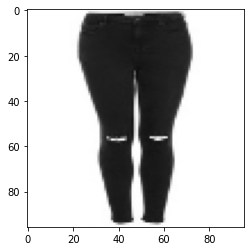

In [ ]:
from IPython.display import Image, display

print(len(data), len(categoryLabels), len(colorLabels))
print("iamgePaths[0]=", imagePaths[0])
display(Image(imagePaths[0]))

print("data[0]=", data[0].shape)
plt.imshow(data[0]/255)
print("categoryLabels[0]=", categoryLabels[0])
print("colorLabels[0]=", colorLabels[0])

#### (4) numpy로 변환

In [ ]:
data = np.array(data, dtype="float")
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

[INFO] data matrix: 755 images (163.08MB)


#### (5) normalization

In [ ]:
data = data/255.

#### (6) 레이블 데이터를 one-hot 인코딩

In [ ]:
print(categoryLabels[:5])
categoryLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
print(categoryLabels[:5])


print(colorLabels[:5])
colorLB = LabelBinarizer()
colorLabels = colorLB.fit_transform(colorLabels)
print(colorLabels[:5])

['jeans' 'jeans' 'shirt' 'jeans' 'dress']
[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
['black' 'black' 'blue' 'black' 'red']
[[1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]]


#### (7) 데이터 분리

In [ ]:
(trainX, testX, trainCategoryY, testCategoryY, trainColorY, testColorY) = train_test_split(data, categoryLabels, colorLabels, test_size=0.2, random_state=42)

print(trainX.shape)
print(trainCategoryY.shape)
print(trainColorY.shape)

print(testX.shape)
print(testCategoryY.shape)
print(testColorY.shape)

(604, 96, 96, 3)
(604, 4)
(604, 3)
(151, 96, 96, 3)
(151, 4)
(151, 3)


In [ ]:
CATEGORY_COUNT = categoryLabels.shape[-1]
COLOR_COUNT = colorLabels.shape[-1]

print(CATEGORY_COUNT)
print(COLOR_COUNT)

4
3


#### (8) 개별 모델로 학습 실행

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def build_category_model():

  model = keras.Sequential()
  model.add(Input(IMAGE_DIMS))
  model.add(Conv2D(32, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(CATEGORY_COUNT, activation='softmax'))

  return model

def build_color_model():

  model = keras.Sequential()
  model.add(Input(IMAGE_DIMS))
  model.add(Conv2D(32, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(COLOR_COUNT, activation='softmax'))

  return model  

In [ ]:
print(trainX.shape)
print(trainCategoryY.shape)
print(CATEGORY_COUNT)

(604, 96, 96, 3)
(604, 4)
4


#### (9) 카테고리 모델

In [ ]:
category_model = build_category_model()

category_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
category_model.summary()


category_model.fit(trainX, trainCategoryY, epochs=5, verbose=1, batch_size=128)


loss, acc = category_model.evaluate(testX, testCategoryY)
print("loss=",loss)
print("acc=",acc)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                309770    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1

#### (10) 컬러 모델

In [ ]:
print(trainX.shape)
print(trainColorY.shape)
print(COLOR_COUNT)

(604, 96, 96, 3)
(604, 3)
3


In [ ]:
color_model = build_color_model()

color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
color_model.summary()


color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)


loss, acc = color_model.evaluate(testX, testColorY)
print("loss=",loss)
print("acc=",acc)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                309770    
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

#### (11) 다중 출력 모델로 학습 실행

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def common_input_branch(input):

  x = Conv2D(32, (3, 3))(input)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3))(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)

  return x


def category_branch(x):

  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(CATEGORY_COUNT, activation='softmax', name='category_output')(x)

  return x

def color_branch(x):

  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(COLOR_COUNT, activation='softmax', name='color_output')(x)

  return x

In [ ]:
input = Input(IMAGE_DIMS)

common_input = common_input_branch(input)
category_output = category_branch(common_input)
color_output = color_branch(common_input)

multi_output_model = Model(input, [category_output, color_output])

multi_output_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 94, 94, 32)   896         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 47, 47, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 45, 45, 64)   18496       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [ ]:
losses = { "category_output":"categorical_crossentropy", "color_output":"categorical_crossentropy"}
loss_weights = { "category_output":1.0, "color_output":1.0}

# color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
multi_output_model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["accuracy"])


# color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)
multi_output_model.fit(trainX, {"category_output":trainCategoryY, "color_output":trainColorY}, epochs=50, verbose=1, batch_size=128)

Train on 604 samples
Epoch 1/50
604/604 [==============================] - 1s 880us/sample - loss: 273.9671 - category_output_loss: 97.8160 - color_output_loss: 170.2181 - category_output_acc: 0.2997 - color_output_acc: 0.3957
Epoch 2/50
604/604 [==============================] - 0s 547us/sample - loss: 75.8908 - category_output_loss: 1.6496 - color_output_loss: 70.9485 - category_output_acc: 0.3543 - color_output_acc: 0.3560
Epoch 3/50
604/604 [==============================] - 0s 524us/sample - loss: 23.3261 - category_output_loss: 10.0313 - color_output_loss: 12.6673 - category_output_acc: 0.3146 - color_output_acc: 0.7169
Epoch 4/50
604/604 [==============================] - 0s 509us/sample - loss: 7.0968 - category_output_loss: 1.3753 - color_output_loss: 5.5770 - category_output_acc: 0.3113 - color_output_acc: 0.7997
Epoch 5/50
604/604 [==============================] - 0s 497us/sample - loss: 3.7273 - category_output_loss: 1.3859 - color_output_loss: 2.2623 - category_output_acc

In [ ]:
loss, category_loss, color_loss, category_acc, color_acc = multi_output_model.evaluate(testX, {"category_output":testCategoryY, "color_output":testColorY})
print("loss=",loss)
print("categoyr_loss=", category_loss)
print("color_loss=", color_loss)
print("category_acc=", category_acc)
print("color_acc=", color_acc)

151/151 [==============================] - 0s 1ms/sample - loss: 2.4729 - category_output_loss: 1.3549 - color_output_loss: 1.2244 - category_output_acc: 0.3377 - color_output_acc: 0.9603
loss= 2.472860945771072
categoyr_loss= 1.3549242
color_loss= 1.2244413
category_acc= 0.33774835
color_acc= 0.9602649
